# Migration Patterns of GPS-Tracked Birds

## Introduction

The wonders of bird migration have captivated scientists and bird enthusiasts alike for centuries. With advancements in GPS tracking technology, we now have the unprecedented ability to study these migratory patterns in fine detail. This notebook presents an analysis of GPS tracking data for three birds to understand their migratory behavior along the coast.

As a Geospatial Data Scientist, I aim to translate complex datasets into meaningful insights, presenting the information in an accessible way to non-experts. The analysis covers several key aspects of bird migration:

- **Travel Distance**: Estimating the total distance each bird has traveled during the study period.
- **Migration Routes**: Mapping the routes taken by each bird and exploring additional insights to understand their migration behavior.
- **Temporal Patterns**: Identifying patterns in the timing of flights to determine when birds are most likely to travel.
- **Stopping Points**: Pinpointing locations where birds stop, which could indicate resting or feeding behavior.

The insights gleaned from this study will not only contribute to our understanding of avian migration but also support strategic decisions in conservation efforts and planning, especially as we work closely with clients in the domain.

By leveraging advanced geospatial data processing, we endeavor to provide a clear picture of the migration patterns, and thereby, lay the groundwork for innovative solutions in the sectors reliant on such pivotal information.

## Initial Visualization of Migration Paths

The first step in our analysis is to create a straightforward visualization of the GPS tracking data for three different birds. This map will give us a visual representation of the paths taken by each bird and highlight any distinct patterns in their movements.

### Process:

- We started by loading the GPS data from a CSV file into a Pandas DataFrame. This data includes latitude, longitude, and time information for each bird.
- A Basemap is then created to provide a geographical context for the data points. We set the map boundaries to include all the points in the dataset.
- Using a different color for each bird, we plotted the GPS coordinates on the map. This allows us to distinguish between the tracks of the different birds.
- The points are plotted as they are read from the dataset, showing us where each bird has been without making any assumptions or calculations about their behavior.

### Results:

- The map gives us an immediate sense of where the birds are spending their time and how they are moving from place to place.
- We can see if there are any common areas that multiple birds visit or if each bird has a distinct route.
- Some areas have denser clusters of points, which could indicate places where birds stop for longer periods.

This visualization is just a starting point. It gives us some initial insights but doesn't yet tell us about the duration of travel, specific stopping points, or flight patterns. We'll dig into these topics in the following sections of the notebook.

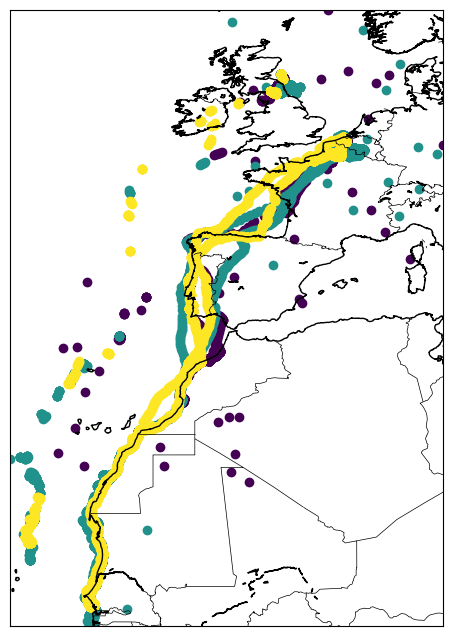

In [4]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('datasets/bird_migration2.csv')

# Create a new figure
plt.figure(figsize=(8, 8))

# Create a Basemap
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat=df['latitude'].min(), urcrnrlat=df['latitude'].max(),
            llcrnrlon=df['longitude'].min(), urcrnrlon=df['longitude'].max())

# Draw coastlines, countries
m.drawcoastlines()
m.drawcountries()

# Convert latitude and longitude to map projection coordinates
x, y = m(df['longitude'].values, df['latitude'].values)

# Create a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(df['bird_name'].unique())))

# Plot the points on the map
for i, bird in enumerate(df['bird_name'].unique()):
    df_bird = df[df['bird_name'] == bird]
    x, y = m(df_bird['longitude'].values, df_bird['latitude'].values)
    m.scatter(x, y, marker='o', color=colors[i])

# Show the plot
plt.show()

## Calculating Total Travel Distances

Following the visualization of the birds' migratory paths, the next analytical step is to quantify the distances traveled by each bird. By doing so, we can compare the extent of their journeys and possibly correlate this with their stops and overall migratory behavior.

### Process:

- The data from the DataFrame was converted into a GeoDataFrame. This format is more suitable for spatial analysis as it can recognize geographic data structures like points, lines, and polygons.
- The data was sorted by each bird's name and the timestamp of the recorded location to ensure a chronological sequence of movements.
- We used the `geodesic` function from the `geopy` library to calculate the distance between consecutive points for each bird. This function takes into account the curvature of the Earth for accurate distance measurement.
- To calculate these distances, we first created a new column to store the previous location of each bird by shifting the geometry column.
- With both the current and previous locations, we then applied the `calculate_distance` function to compute the distance between consecutive points.
- Finally, we aggregated these distances by each bird to determine their total travel distance.

### Results:

- The output table presents the total distance traveled in kilometers for each bird. 
- The distances are rounded to the nearest tenth of a kilometer for readability.
- From the results, we can observe that Nico has traveled the furthest, followed closely by Eric and then Sanne.

This analysis provides a clear numerical basis for understanding the scope of the birds' migrations and sets the stage for more detailed investigations into their behavioral patterns during these long journeys.

In [5]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin
from geopy.distance import geodesic

# Convert DataFrame to GeoDataFrame by creating Point geometry from latitude and longitude
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Ensure the data is sorted by bird_name and date_time
gdf.sort_values(by=['bird_name', 'date_time'], inplace=True)

# Function to calculate the distance between points
def calculate_distance(row):
    if row['prev_geometry']:
        return geodesic((row['prev_geometry'].y, row['prev_geometry'].x), (row['geometry'].y, row['geometry'].x)).kilometers
    return 0

# Shift the geometry column to get the previous location
gdf['prev_geometry'] = gdf.groupby('bird_name')['geometry'].shift(1)

# Calculate the distance between consecutive points
gdf['distance'] = gdf.apply(calculate_distance, axis=1)

# Sum the distances for each bird to get the total travel distance
total_distance = gdf.groupby('bird_name')['distance'].sum().reset_index()

# Rename columns and format distance
total_distance.rename(columns={'bird_name': 'Bird Name', 'distance': 'Distance (km)'}, inplace=True)
total_distance['Distance (km)'] = total_distance['Distance (km)'].round(1)

# Print the total travel distances
print(total_distance)

  Bird Name  Distance (km)
0      Eric       189426.1
1      Nico       205296.7
2     Sanne       186577.5


## Detailed Migration Routes with Time Progression

After the initial exploration of the migration paths, we focused on visualizing each bird's route with a temporal aspect to illustrate the progression of their journey over time.

### Process:

- We began by ensuring the data was in proper chronological order, sorting by `bird_name` and `date_time`.
- A separate map was plotted for each bird to avoid clutter and provide a clear view of their individual migration patterns.
- Basemaps were created with boundaries adjusted to each bird's data, ensuring the entire route was visible and centered on the map.
- Points along the migration route were color-coded to reflect the time progression, with colors transitioning from start (oldest points) to end (most recent points) of the dataset.
- The start and end points of each bird's migration were marked with distinct colors and labels to identify the beginning and end of the tracked period.
- A colorbar was added as a visual aid to interpret the color gradient in terms of time, with tick marks representing dates evenly distributed throughout the migration period.

### Results:

- The output consists of three maps, each corresponding to one of the birds tracked: Eric, Nico, and Sanne.
- On each map, the route taken by the bird is clear, with the color gradient effectively showing the temporal aspect of their migration.
- By observing the color transitions, we can infer periods of rapid movement (closely spaced points with quickly changing colors) versus periods of relative inactivity (clusters of similar colors).
- The annotated start and end points, along with the color-coded paths, offer a comprehensive view of the migration timeline.

These detailed maps provide valuable insights into not only the paths taken but also the timing of the birds' movements. This information is critical for understanding migration patterns, such as identifying favored habitats, seasonal changes, and potential environmental impacts on migratory behavior.

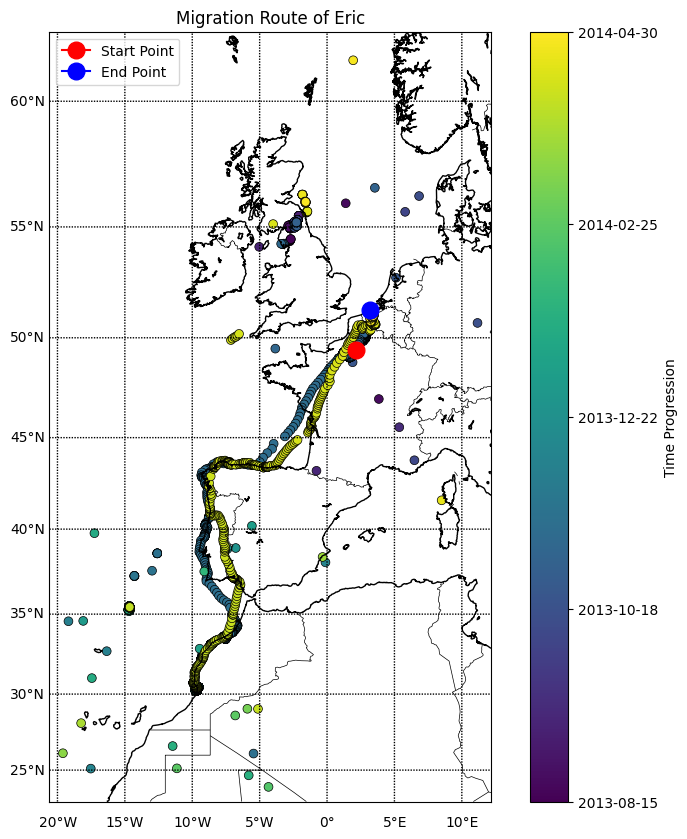

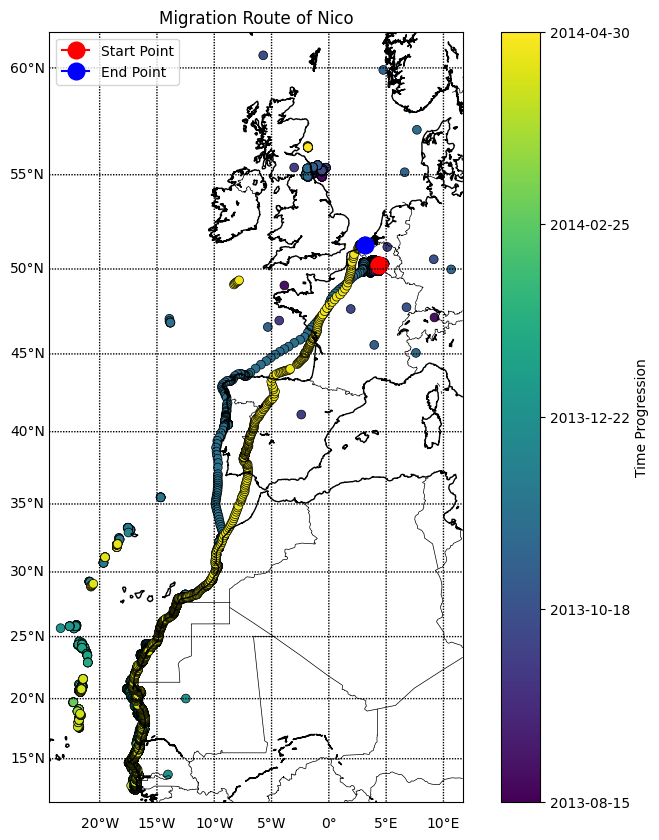

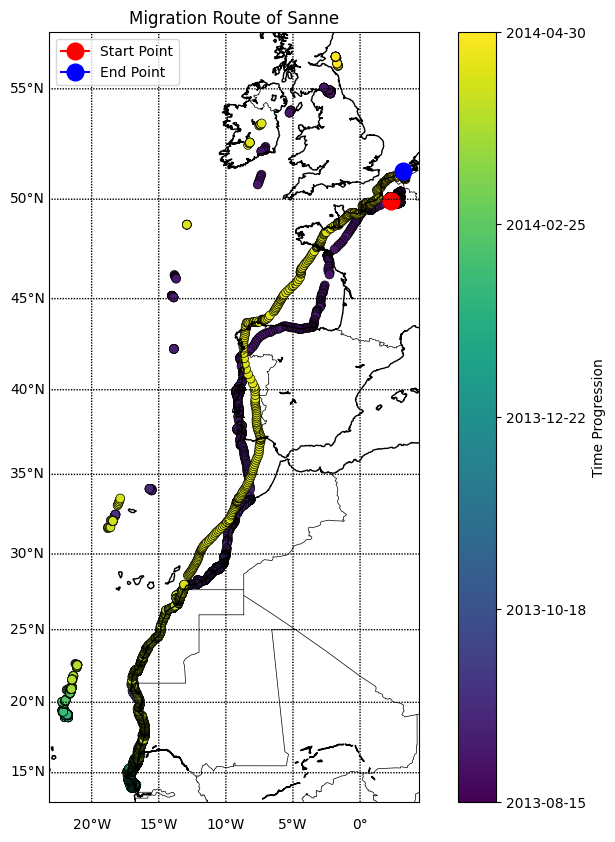

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('datasets/bird_migration2.csv')

# Convert 'date_time' from string to datetime for easier handling
df['date_time'] = pd.to_datetime(df['date_time'])

# Ensure data is sorted by bird_name and date_time for plotting
df.sort_values(by=['bird_name', 'date_time'], inplace=True)

# Iterate over each unique bird
for bird in df['bird_name'].unique():
    # Filter data for the current bird
    bird_data = df[df['bird_name'] == bird]

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Create a Basemap
    m = Basemap(projection='merc', resolution='i', 
                llcrnrlat=bird_data['latitude'].min() - 1, urcrnrlat=bird_data['latitude'].max() + 1,
                llcrnrlon=bird_data['longitude'].min() - 1, urcrnrlon=bird_data['longitude'].max() + 1)

    # Draw coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Convert latitude and longitude to map projection coordinates
    x, y = m(bird_data['longitude'].values, bird_data['latitude'].values)

    # Create a gradient color based on the index, using a colormap
    cmap = plt.get_cmap('viridis')
    colors = np.linspace(0, 1, len(bird_data))

    # Plot the points on the map
    sc = m.scatter(x, y, c=colors, cmap=cmap, edgecolor='k', linewidth=0.5, s=40)

    # Annotate the start and end points
    m.plot(x[0], y[0], marker='o', color='red', markersize=12, label='Start Point')  # Start point
    m.plot(x[-1], y[-1], marker='o', color='blue', markersize=12, label='End Point')  # End point

    # Colorbar to indicate time progression
    cbar = plt.colorbar(sc, orientation='vertical')
    cbar.set_label('Time Progression')

    # Calculate positions for intermediate ticks
    tick_positions = np.linspace(0, 1, num=5)  # Adjust 'num' for more or fewer ticks
    tick_labels = pd.to_datetime(np.linspace(bird_data['date_time'].min().value, bird_data['date_time'].max().value, num=5)).strftime('%Y-%m-%d')

    cbar.set_ticks(tick_positions)
    cbar.ax.set_yticklabels(tick_labels)

    # Add legend with information about the markers
    plt.legend(loc='upper left')

    # Add grid lines and title
    m.drawparallels(np.arange(-90., 120., 5.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)
    plt.title(f'Migration Route of {bird}')

    # Show the plot
    plt.show()

## Identifying Southernmost Points

To complement our understanding of the birds' migratory behavior, we sought to determine the southernmost point each bird reached during its journey, as this could indicate wintering grounds or key stopover points.

### Process:

- The tracking data was loaded into a DataFrame, and the `date_time` column was converted into a datetime object for precise temporal analysis.
- We looped through each bird to isolate its specific data and identify the point with the lowest latitude, which corresponds to the southernmost position.
- The latitude was formatted to include the hemisphere designation and rounded to one decimal place for clarity.
- For each bird, we recorded the date they reached this southernmost point, formatted to a human-readable form.
- These details were compiled into a new DataFrame, which was then sorted by the date on which each bird reached its southernmost latitude, providing a chronological sequence of these significant events.

### Results:

- The resulting table presents a clear and sorted list of when each bird reached its southernmost point during the tracking period.
- Sanne reached her southernmost point first, followed by Eric and then Nico.
- Alongside the dates and locations, the average velocity of each bird is also displayed, offering insight into their travel speeds leading up to these points.

This information is particularly valuable as it may reflect patterns related to climate, habitat preference, or other ecological factors driving the birds' migratory choices. Such data can be crucial for conservation efforts and for enhancing our general knowledge of migratory behaviors.

In [8]:
import pandas as pd
from geopy.distance import geodesic

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('datasets/bird_migration2.csv')

# Convert 'date_time' from string to datetime for easier handling
df['date_time'] = pd.to_datetime(df['date_time'])

# Initialize a list to store the results
southernmost_dates = []

# Iterate over each unique bird
for bird in df['bird_name'].unique():
    # Filter data for the current bird
    bird_data = df[df['bird_name'] == bird].sort_values(by='date_time')
    
    # Calculate distances between consecutive points
    previous_points = bird_data[['latitude', 'longitude']].shift(1)
    distances = bird_data.apply(lambda row: geodesic((row['latitude'], row['longitude']),
                                                     (previous_points.loc[row.name, 'latitude'], 
                                                      previous_points.loc[row.name, 'longitude'])).kilometers if not pd.isna(previous_points.loc[row.name, 'latitude']) else 0, axis=1)

    # Calculate time differences in hours
    time_deltas = bird_data['date_time'].diff().dt.total_seconds() / 3600  # Convert to hours

    # Calculate average velocity (km/h), avoiding division by zero
    total_distance = distances.sum()
    total_time = time_deltas.sum()
    average_velocity = total_distance / total_time if total_time > 0 else 0
    
    # Find the southernmost point (minimum latitude)
    southernmost_data = bird_data[bird_data['latitude'] == bird_data['latitude'].min()].iloc[0]
    
    # Format the latitude
    latitude = southernmost_data['latitude']
    hemisphere = "N" if latitude >= 0 else "S"
    formatted_latitude = f"{abs(latitude):.1f}° {hemisphere}"
    
    # Format the date as "Month day, year"
    formatted_date = southernmost_data['date_time'].strftime('%B %d, %Y')
    
    # Append the bird name, the date they reached the southernmost point, latitude, and average velocity to the list
    southernmost_dates.append((bird, formatted_date, formatted_latitude, average_velocity))

# Create a DataFrame from the list
southernmost_df = pd.DataFrame(southernmost_dates, columns=['Bird Name', 'Date Reached Southernmost Point', 'Southernmost Latitude', 'Average Velocity (km/h)'])

# Sort the DataFrame by the date reached southernmost point
southernmost_df['Date Reached Southernmost Point'] = pd.to_datetime(southernmost_df['Date Reached Southernmost Point'])
southernmost_df.sort_values(by='Date Reached Southernmost Point', inplace=True)

# Convert dates back to the desired format for display
southernmost_df['Date Reached Southernmost Point'] = southernmost_df['Date Reached Southernmost Point'].dt.strftime('%B %d, %Y')

# Display the DataFrame
print(southernmost_df)

  Bird Name Date Reached Southernmost Point Southernmost Latitude  \
2     Sanne                January 05, 2014               13.9° N   
0      Eric               February 14, 2014               23.9° N   
1      Nico                  March 23, 2014               12.4° N   

   Average Velocity (km/h)  
2                30.015813  
0                30.476128  
1                33.031498  


## Analyzing Daily Average Velocity

The focus of this part of the analysis is to calculate and visualize the daily average velocity for each bird throughout the migration period. This provides insights into their travel speeds and may indicate different behaviors, such as periods of rest or extended flight.

### Process:

- After loading the tracking data, we processed it to calculate the daily average velocity for each bird.
- We calculated the distances between consecutive GPS points using the `geodesic` function, which takes the curvature of the Earth into account.
- We determined the time difference between consecutive points and calculated the velocity in kilometers per hour.
- To smooth out the daily fluctuations and highlight overall trends, we applied a 21-day rolling average to the velocity data.
- Finally, we plotted these smoothed velocities on a line chart, with each bird represented by a unique line, allowing us to compare their movement speeds over time.

### Results:

- The line chart clearly shows the variation in daily average velocity for each bird.
- The rolling average smooths out the data, making it easier to observe long-term trends and patterns in the birds' velocities.
- We see periods where the velocity increases, suggesting sustained flight, and periods where the velocity decreases, which could indicate resting phases.
- The graph gives us a temporal perspective of the birds' flight behaviors, which can be correlated with environmental factors like weather patterns or geographic obstacles.

This velocity analysis is crucial for understanding the birds' migration strategies, such as when they choose to travel quickly, when they slow down, and how they might be influenced by external conditions.

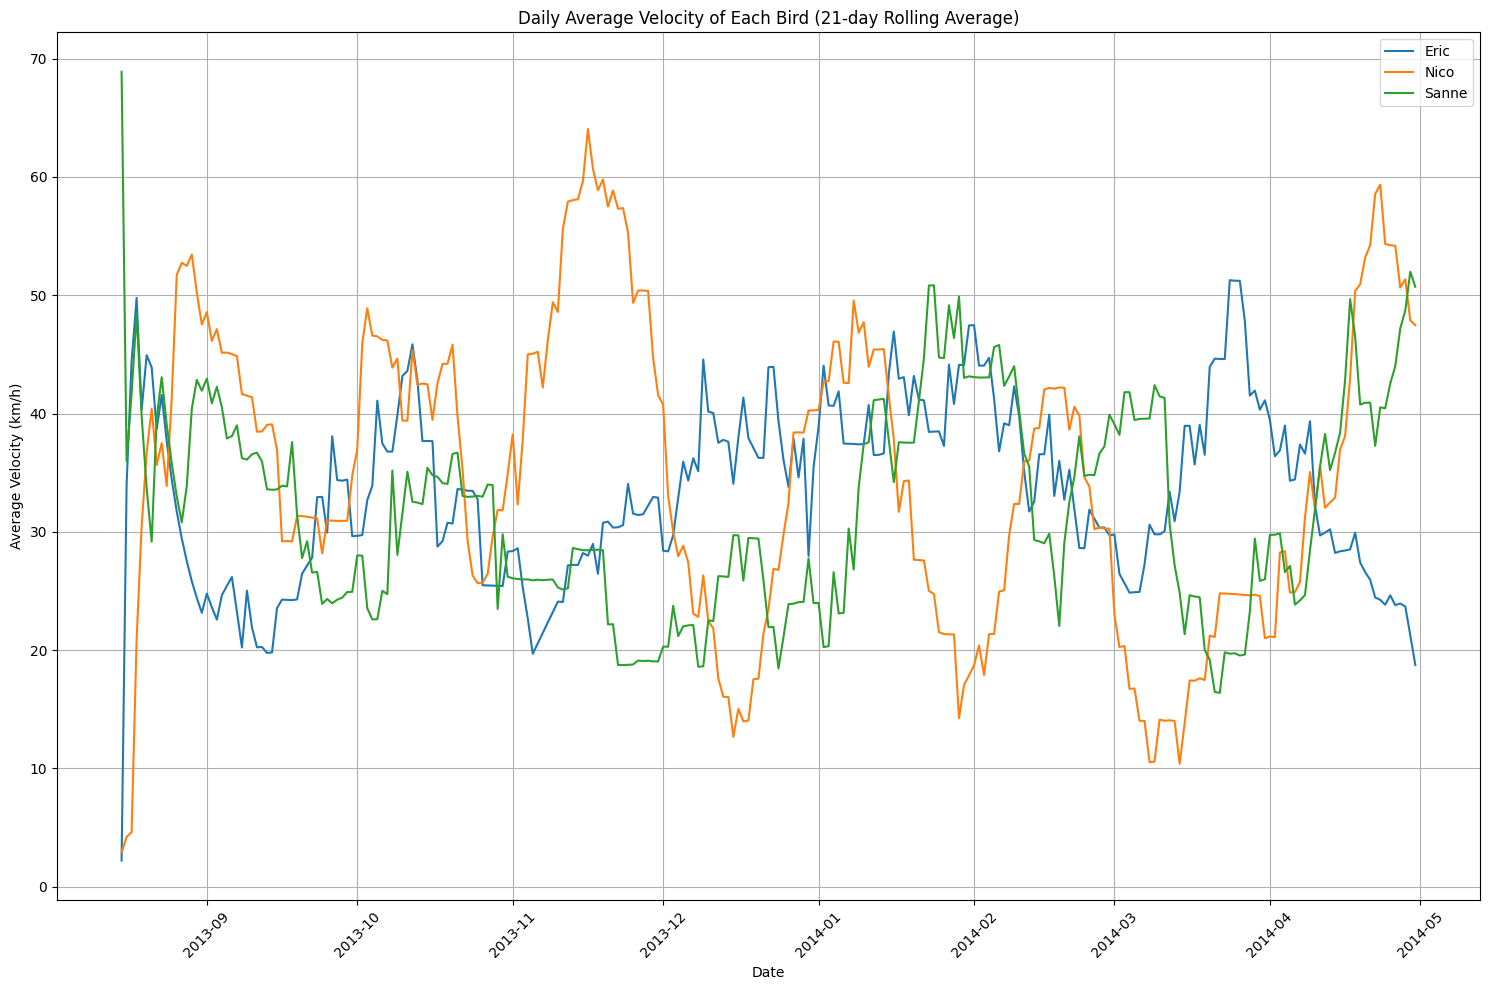

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Load the CSV data into a pandas DataFrame
df = pd.read_csv('datasets/bird_migration2.csv')

# Convert 'date_time' from string to datetime for easier handling
df['date_time'] = pd.to_datetime(df['date_time'])

# Preparing a DataFrame to store velocities per bird per day
velocity_df = pd.DataFrame()

# Iterate over each unique bird
for bird in df['bird_name'].unique():
    # Filter data for the current bird
    bird_data = df[df['bird_name'] == bird].sort_values(by='date_time')

    # Calculate distances between consecutive points
    previous_points = bird_data[['latitude', 'longitude']].shift(1)
    distances = bird_data.apply(lambda row: geodesic((row['latitude'], row['longitude']),
                                                     (previous_points.loc[row.name, 'latitude'], 
                                                      previous_points.loc[row.name, 'longitude'])).kilometers if not pd.isna(previous_points.loc[row.name, 'latitude']) else 0, axis=1)

    # Calculate time differences in hours
    time_deltas = bird_data['date_time'].diff().dt.total_seconds() / 3600  # Convert to hours

    # Calculate velocities in km/h, avoiding division by zero
    velocities = distances / time_deltas.replace(0, pd.NA)

    # Store daily average velocities
    bird_data['velocity'] = velocities
    daily_average_velocity = bird_data.groupby(bird_data['date_time'].dt.date)['velocity'].mean().reset_index()
    daily_average_velocity['bird_name'] = bird  # Add bird name for identification

    # Append to the main DataFrame
    velocity_df = pd.concat([velocity_df, daily_average_velocity], ignore_index=True)

# Assuming 'velocity_df' is already created as per previous instructions

import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(15, 10))

rolling_window_size = 21

for bird in velocity_df['bird_name'].unique():
    bird_velocities = velocity_df[velocity_df['bird_name'] == bird]
    bird_velocities.set_index('date_time', inplace=True)
    
    # Exclude the first measurement by starting from the second data point
    rolling_velocities = bird_velocities['velocity'].iloc[0:].rolling(window=rolling_window_size, min_periods=0).mean()
    
    ax.plot(rolling_velocities.index, rolling_velocities, label=bird)

# Improve date formatting on the x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add labels, title, and grid
ax.set_xlabel('Date')
ax.set_ylabel('Average Velocity (km/h)')
ax.set_title('Daily Average Velocity of Each Bird (21-day Rolling Average)')
ax.legend()
ax.grid(True)

# Rotate date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

## Hourly Average Velocity Analysis

To gain further insight into the birds' migratory behavior, we analyzed their average velocities throughout the day. This helps to identify the times when the birds are most active and potentially the times when they are resting.

### Process:

- We extended the dataset to include a calculation of the distance between consecutive GPS points for all recorded locations.
- Time differences were calculated, converting the result into hours.
- Using these two new metrics, we computed the velocity for each recorded location in kilometers per hour.
- We then grouped the data by bird and hour of the day to find the average velocity during each hour across all days.
- A pivot table was created to restructure the data, setting the hour of the day as the index and the bird names as columns.
- This data was plotted in a line chart, showing the hourly average velocity of each bird, with distinct colors for each bird and markers at each data point.

### Results:

- The chart reveals the patterns in each bird's movement throughout the day, with peaks indicating higher average velocities and troughs suggesting periods of lower activity.
- We can observe that some birds have clear periods of inactivity, possibly at night, while others have more varied patterns.
- Differences in peak activity times among the birds can be seen, which might relate to their specific migration strategies or environmental factors like daylight hours and weather conditions.

This hourly velocity analysis contributes to our understanding of when the birds are most likely to travel and how their daily movement patterns might vary. It's a detailed look at their daily routines, which could be influenced by factors such as the availability of light, weather conditions, and the need for rest and foraging.

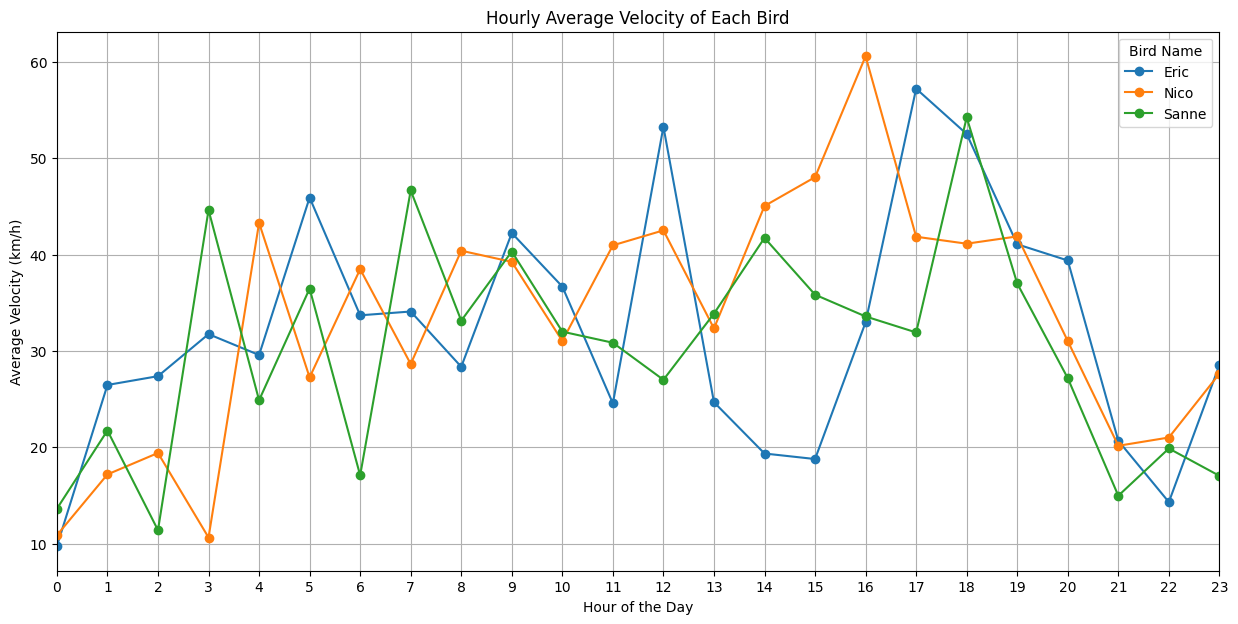

In [10]:
# Calculate distances between consecutive points for the entire df
previous_points = df[['latitude', 'longitude']].shift(1)
df['distances'] = df.apply(
    lambda row: geodesic(
        (row['latitude'], row['longitude']), 
        (previous_points.loc[row.name, 'latitude'], previous_points.loc[row.name, 'longitude'])
    ).kilometers if not pd.isna(previous_points.loc[row.name, 'latitude']) else 0, axis=1
)

# Calculate time differences in hours for the entire df
df['time_deltas'] = df['date_time'].diff().dt.total_seconds() / 3600  # Convert to hours

# Calculate velocities in km/h for the entire df, avoiding division by zero
df['velocity'] = df['distances'] / df['time_deltas'].replace(0, pd.NA)

# Group the data by bird and by the hour of the day, then calculate the average velocity
df['hour'] = df['date_time'].dt.hour
hourly_velocity = df.groupby(['bird_name', 'hour'])['velocity'].mean().reset_index()

# Pivot to have hours as the index and birds as the columns for average velocities
hourly_pivot = hourly_velocity.pivot(index='hour', columns='bird_name', values='velocity')

# Plotting the average velocity for each bird by hour of the day
fig, ax = plt.subplots(figsize=(15, 7))
hourly_pivot.plot(ax=ax, marker='o')

# Formatting the plot
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Velocity (km/h)')
ax.set_title('Hourly Average Velocity of Each Bird')
ax.grid(True)
ax.set_xticks(range(24))  # Set x-ticks to be every hour
ax.set_xlim(0, 23)  # Set the x-limit to cover full 24 hours
ax.legend(title='Bird Name')

# Show the plot
plt.show()

## Mapping Stopping Points Based on Velocity

The aim of this analysis is to identify when and where the birds are likely stopping during their migration. This is done by defining a low-velocity threshold that, when met, suggests a bird is resting or foraging rather than traveling.

### Process:

- Starting with the DataFrame where we've already calculated velocities, we computed a 7-day rolling average velocity for each bird. This helps smooth short-term variations and gives a better indication of sustained low movement periods.
- We then set a very low threshold velocity (0.01 km/h) to represent when birds are effectively stationary. This threshold can be adjusted based on knowledge of the birds' behavior.
- Data points where the bird's 7-day rolling average velocity fell below this threshold were flagged as potential stopping points.
- Given the potentially large number of stopping points, a random sample was taken for visualization, ensuring manageability and clarity in the map presentation.
- A Basemap was then set up with dynamic boundaries based on the latitude and longitude of the sampled stopping points, with a small buffer for better visualization.
- These points were plotted on the map with different colors representing each bird, providing a visual of where birds have stopped during their migration.

### Results:

- The visualization shows clusters of stopping points, which could indicate important habitats for resting or feeding.
- By displaying stopping points across the entire migratory range, we see where birds spend significant time, which may be of ecological or conservational interest.
- The map can reveal if multiple birds share common stopping areas, which might suggest prime locations that are important for various species.

Identifying these stopping points is crucial for understanding the birds' behavior during migration and can assist in protecting these key areas, which may serve as critical refuges during long flights.

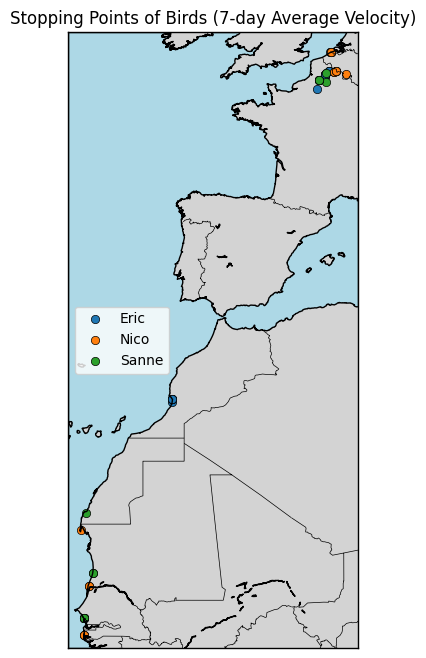

In [27]:
import pandas as pd
from geopy.distance import geodesic
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Assume that the velocity has already been calculated and is stored in the DataFrame
# If not, insert the velocity calculation code here
# ...

# Calculate the 7-day rolling average velocity
df['velocity_7day_avg'] = df.groupby('bird_name')['velocity'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Define a threshold velocity below which we consider the bird to be stopping
velocity_threshold = 0.01  # km/h, this is an example threshold

# Identify stopping periods when the 7-day rolling average velocity is below the threshold
df['is_stopping'] = df['velocity_7day_avg'] < velocity_threshold

# Filter out stopping points
stopping_points = df[df['is_stopping']]

# Assuming we have a large dataset, let's take a sample for visualization
stopping_points_sample = stopping_points.sample(n=min(1000, len(stopping_points)), random_state=1)

# Determine the map boundaries dynamically
buffer = 1  # smaller buffer for more zoom
llcrnrlon = stopping_points_sample['longitude'].min() - buffer
urcrnrlon = stopping_points_sample['longitude'].max() + buffer
llcrnrlat = stopping_points_sample['latitude'].min() - buffer
urcrnrlat = stopping_points_sample['latitude'].max() + buffer

# Set up the map with the calculated boundaries
plt.figure(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat, 
            urcrnrlon=urcrnrlon, urcrnrlat=urcrnrlat, 
            lat_ts=(llcrnrlat+urcrnrlat)/2, resolution='i')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Plot stopping points for each bird using the sample
for bird in stopping_points_sample['bird_name'].unique():
    bird_stopping_points = stopping_points_sample[stopping_points_sample['bird_name'] == bird]
    x, y = m(bird_stopping_points['longitude'].values, bird_stopping_points['latitude'].values)
    m.scatter(x, y, label=bird, edgecolor='k', linewidth=0.5)

plt.legend()
plt.title('Stopping Points of Birds (7-day Average Velocity)')
plt.show()

## Clustering Stopping Points and Determining Staying Durations

In this part of the analysis, we dive deeper into the stopping behavior of the birds by using clustering algorithms to identify areas where birds have stopped and to estimate how long they stayed in each area.

### Process:

- We continued working with the subset of the DataFrame where stopping points were identified based on the 7-day rolling average velocity being below a certain threshold.
- A density-based spatial clustering algorithm (DBSCAN) was applied to the stopping points to group nearby locations, using a radius of 500 meters to define clusters.
- For each cluster, the centroid was calculated, which represents the approximate central location where the bird stayed.
- We joined the centroid information back to the stopping points data to associate each stopping point with its corresponding cluster's centroid.
- Grouping the data by bird and cluster, we aggregated the earliest and latest dates to establish the approximate period each bird stayed near the centroid of a cluster.
- The start and end dates were adjusted by adding and subtracting 3.5 days, respectively, to provide a more conservative estimate of the duration of stay.

### Results:

- The output table lists each bird, along with the coordinates of the centroids of the clusters where they stopped, and the adjusted start and end dates of their stays.
- This table provides an approximation of the birds' resting locations during migration and the duration of their stops at these locations.
- By observing the dates and durations, we can infer patterns in stopping behavior, such as longer stays in certain areas, which may suggest important resting or feeding sites.

This clustering and duration estimation step is essential for understanding the stopover ecology of the birds. It identifies key areas that might be critical for the birds' survival during migration and can inform further ecological studies or conservation efforts.

In [32]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint
from datetime import timedelta

# Extracting the required information
stopping_points_table = stopping_points_sample[['bird_name', 'date_time', 'latitude', 'longitude']]

# Formatting the date_time to display only the date for readability
stopping_points_table['date'] = stopping_points_table['date_time'].dt.date

# Display the table with the points that are visualized on the map
# Here we are dropping the original date_time column as we now have a formatted date column

# Assume df and stopping_points_sample are defined as above
# Ensure you have the 'date' column correctly generated
stopping_points_sample['date'] = stopping_points_sample['date_time'].dt.date

# Define the distance threshold for clustering, in kilometers
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian  # 500 meters radius for clustering

# Convert lat, lon to radians for the clustering algorithm
coords = np.radians(stopping_points_sample[['latitude', 'longitude']].values)
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
stopping_points_sample['cluster'] = db.fit_predict(coords)

# Calculate centroid of each cluster
clusters = stopping_points_sample.groupby('cluster')[['latitude', 'longitude']].apply(
    lambda x: MultiPoint(x.to_numpy()).centroid.coords[0]
)
clusters = pd.DataFrame(clusters.tolist(), columns=['centroid_lat', 'centroid_lon'], index=clusters.index)

# Join centroids back to the main DataFrame
stopping_points_sample = pd.merge(stopping_points_sample, clusters, left_on='cluster', right_index=True, how='left')

# Group by bird and cluster, then calculate the date range, adjust by 3.5 days
date_ranges = stopping_points_sample.groupby(['bird_name', 'cluster']).agg(
    start_date=('date', 'min'),
    end_date=('date', 'max'),
    centroid_lat=('centroid_lat', 'first'),
    centroid_lon=('centroid_lon', 'first')
).reset_index()

# Adjust the start_date and end_date by 3.5 days
date_ranges['approx_start_date'] = date_ranges['start_date'] - timedelta(days=3.5)
date_ranges['approx_end_date'] = date_ranges['end_date'] + timedelta(days=3.5)

# Prepare the final output, using adjusted dates
final_output = date_ranges[['bird_name', 'centroid_lat', 'centroid_lon', 'approx_start_date', 'approx_end_date']]

print(final_output)

   bird_name  centroid_lat  centroid_lon approx_start_date approx_end_date
0       Eric     50.192085      2.732721        2013-08-26      2013-10-23
1       Eric     30.220134     -9.633972        2014-01-09      2014-01-15
2       Eric     30.430684     -9.641939        2013-12-18      2014-01-25
3       Eric     49.938664      2.271959        2013-08-18      2013-08-29
4       Eric     50.288268      2.818554        2013-10-03      2013-10-09
5       Eric     51.352350      3.175978        2014-04-14      2014-04-27
6       Eric     50.366649      3.025016        2013-08-28      2013-09-03
7       Eric     50.198555      2.737299        2013-09-22      2013-09-28
8       Eric     49.419880      2.120746        2013-08-12      2013-08-18
9       Nico     50.369187      3.615080        2013-08-30      2013-09-05
10      Nico     50.369804      3.606599        2013-08-26      2013-09-01
11      Nico     12.745047    -16.786124        2014-03-28      2014-04-03
12      Nico     50.37546

## Conclusion

Throughout this notebook, we've leveraged the power of geospatial data analysis to gain a deeper understanding of bird migration patterns. Starting with broad route visualizations, we advanced through detailed examinations of travel distances, hourly and daily velocities, and stopping behaviors.

Key takeaways from our analysis include:
- **Distance Travelled**: Each bird covered an impressive distance during the tracking period, with Nico traveling the farthest.
- **Migration Routes**: Individual maps for each bird provided clear visualizations of their migratory paths and highlighted significant waypoints in their journeys.
- **Temporal Patterns**: We observed distinct periods of activity and rest, and how these patterns varied among the birds, likely influenced by the availability of daylight and other environmental factors.
- **Stopping Points**: By applying a clustering algorithm, we pinpointed where birds stopped during their migrations and estimated the duration of each stop, revealing potential areas of ecological importance.

The insights derived from this study are not only fascinating from an ornithological perspective but also carry significant implications for conservation efforts. Understanding where and when birds travel and rest can help in the creation and management of protected areas, potentially aiding in the survival of these species during their demanding migratory journeys.

Moreover, the methodologies demonstrated here showcase the capabilities of modern data science in addressing complex biological questions. They represent a blend of technical prowess and ecological inquiry, and they hold the promise for further applications in diverse fields where geospatial data is pivotal.

In conclusion, this exploratory journey through the data has provided us with a richer picture of the birds' migration strategies, while also opening the door for more detailed studies in the future. It has been a blend of analytical rigor and biological curiosity, and it is hoped that the findings will contribute to ongoing conservation efforts and raise awareness of the remarkable phenomena of bird migration.